# Connect drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!cp -R '/content/drive/MyDrive/Audio' '/content/'

In [ ]:
!pip install transformers
!pip install tensorboardx

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.backend_bases import RendererBase
from scipy import signal
from scipy.io import wavfile
import os
from PIL import Image
from scipy.fftpack import fft
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tensorboardX import SummaryWriter
import sklearn

## Read list file

In [ ]:
import os
import chardet

def file_search(dirname, ret, list_avoid_dir=[]):
    filenames = os.listdir(dirname)
    
    for filename in filenames:
        full_filename = os.path.join(dirname, filename)

        if os.path.isdir(full_filename) :
            if full_filename.split('/')[-1] in list_avoid_dir:
                continue
            else:
                file_search(full_filename, ret, list_avoid_dir)
            
        else:
            ret.append( full_filename ) 

In [ ]:
list_files = []
n_samples = {'Angry': 0,'Neutral':0}
type_emotion = ['Angry','Neutral']
path_parent = "/content/Audio/data_2_emotion/"
for name in type_emotion:
  path = path_parent + name
  list_file=[]
  file_search(path, list_file)
  list_files = list_files + list_file
  n_sample = len(list_file)
  n_samples[name] = n_sample
  print (name + ", #sum files: " + str(n_sample))

Angry, #sum files: 310
Neutral, #sum files: 310


In [ ]:
list_files

## create dataframe (filename, label)

In [ ]:
import pandas as pd

0 là angry, 1 là normal

In [ ]:
__label = np.concatenate([np.zeros(n_samples["Angry"]),np.ones(n_samples["Neutral"])])
df = pd.DataFrame({"filename": list_files,"label":__label})

# Khám phá dữ liệu

0.0    50.0
1.0    50.0
Name: label, dtype: float64

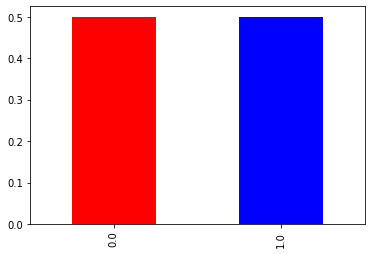

In [ ]:
df.label.value_counts(normalize=True).plot(kind="bar", color=["red", "blue", "green", "orange"])
df['label'].value_counts(normalize=True) * 100

## read audio


In [ ]:
list_sound = []
list_sr = []
times = []
for _path in list_files:
  temp_sound,samplerate  = librosa.load(_path)
  list_sound.append(temp_sound)
  list_sr.append(samplerate)
  times.append(librosa.get_duration(y=temp_sound, sr=samplerate))

In [ ]:
df_length_time = pd.DataFrame({"filename": list_files,"length (s)":times})

In [ ]:
import statistics

In [ ]:
print(f"min length: {min(times)}\n max length: {max(times)}\n mean: {statistics.mean(times)}\n median: {statistics.median(times)}")

min length: 2.414875283446712
 max length: 38.63469387755102
 mean: 12.329815668202764
 median: 12.788027210884353


In [ ]:
import seaborn as sns

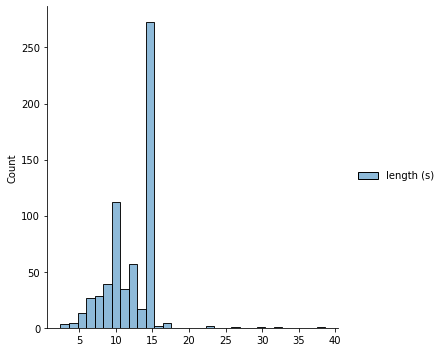

In [ ]:
sns.displot(df_length_time)

## Data

In [ ]:
list_sound = np.load("/content/Audio/data_2_emotion/data_sound.npy",allow_pickle=True)
list_sr = np.load("/content/Audio/data_2_emotion/data_sr.npy",allow_pickle=True)
__label = np.load("/content/Audio/data_2_emotion/data_lb.npy",allow_pickle=True)

In [ ]:
data_orignal = pd.DataFrame({"sound": list_sound,"samplerate": list_sr,"label": __label})

In [ ]:
'''
np.save('/content/Audio/data_2_emotion/data_sound',list_sound)
np.save('/content/Audio/data_2_emotion/data_sr',list_sr)
np.save('/content/Audio/data_2_emotion/data_lb',__label)
'''

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [ ]:
#data_orignal.to_csv("/content/drive/MyDrive/Audio/YouTubeCutted/data.csv",sep='\t',index=False)

In [ ]:
#lengths = data_orignal["sound"].apply(len)

In [ ]:
#[lengths < 400000]

In [ ]:
#data_orignal=data_orignal[lengths < 400000].reset_index(drop=True)

# Chuẩn bị dữ liệu


In [ ]:
def copy_data(input):
  keys = input.keys()
  dic = {}
  for i in range(len(keys)):
    dic[keys[i]]=input[keys[i]]
  return pd.DataFrame(dic)

## padding

In [ ]:
class Padding:
  length_largest = 0
  def __init__(self,data):
    self.data=data
  ## find index length max
  def find_time_largest(self):
    times = []
    for i in range(len(self.data["label"])):
      times.append(librosa.get_duration(y=self.data["sound"][i], sr=self.data["samplerate"][i]))
    self.length_largest = len(self.data["sound"][pd.DataFrame(times).idxmax()[0]])
  def padding_data(self):
    for i in range(0,len(self.data["label"])):
      self.data["sound"][i] = librosa.util.fix_length(self.data["sound"][i], self.length_largest)

In [ ]:
#test_padding = copy_data(data_orignal)
#temp = Padding(test_padding)

In [ ]:
#temp.find_time_largest()

In [ ]:
#temp.length_largest

In [ ]:
#temp.padding_data()

In [ ]:
#temp.data["sound"][0]

## Normalize

In [ ]:
def normalize(df):
  for i in range(len(df.data["sound"])):
    df.data["sound"][i]=librosa.util.normalize(df.data["sound"][i])

## Data augmentation

In [ ]:
class Data_Augmentation:
  def __init__(self, data, percent):
    self.data = data
    self.percent = percent
  ## add noise
  def noise(self,data):
    noise_amp = 0.05*np.random.uniform()*np.amax(data)   # more noise reduce the value to 0.5
    out_data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return out_data
  ## shift
  def shift(self,data):
    s_range = int(np.random.uniform(low=-5, high = 5)*1000)  #default at 500
    return np.roll(data, s_range)
  ## stretch
  def stretch(self, data, rate=0.8):
    """
    Streching the Sound. Note that this expands the dataset slightly
    """
    out_data = librosa.effects.time_stretch(data, rate)
    return out_data
  ## pitch
  def pitch(self, data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data_out = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data_out
  ## dynamic change
  def dyn_change(self,data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=-0.5 ,high=7)  # default low = 1.5, high = 3
    return (data * dyn_change)
  ## speed and pitch
  def speedNpitch(self, data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.2  / length_change # try changing 1.0 to 2.0 ... =D
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

  def augument(self,type_aug):
    if self.percent == 0:
      return
    table_0 = self.data[self.data["label"]==0]
    table_1 = self.data[self.data["label"]==1]
    select_data_aug = pd.concat([table_0.sample(frac=self.percent), table_1.sample(frac=self.percent)], ignore_index=True)
    data_aug_noise = copy_data(select_data_aug)
    data_aug_shift = copy_data(select_data_aug)
    data_aug_stretch = copy_data(select_data_aug)
    data_aug_pitch = copy_data(select_data_aug)
    data_aug_dyn_change = copy_data(select_data_aug)
    data_aug_speedNpitch = copy_data(select_data_aug)
    for i in range(len(select_data_aug["label"])):
        data_aug_noise["sound"][i] = self.noise(select_data_aug["sound"][i])
        data_aug_shift["sound"][i] = self.shift(select_data_aug["sound"][i])
        data_aug_stretch["sound"][i] = self.stretch(select_data_aug["sound"][i])
        data_aug_pitch["sound"][i] = self.pitch(select_data_aug["sound"][i],select_data_aug["samplerate"][i])
        data_aug_dyn_change["sound"][i] = self.dyn_change(select_data_aug["sound"][i])
        data_aug_speedNpitch["sound"][i] = self.speedNpitch(select_data_aug["sound"][i])
    self.data = pd.concat([self.data,data_aug_noise], ignore_index=True)
    self.data = pd.concat([self.data,data_aug_shift], ignore_index=True)
    self.data = pd.concat([self.data,data_aug_stretch], ignore_index=True)
    self.data = pd.concat([self.data,data_aug_pitch], ignore_index=True)
    self.data = pd.concat([self.data,data_aug_dyn_change], ignore_index=True)
    self.data = pd.concat([self.data,data_aug_speedNpitch], ignore_index=True)
    '''
    if type_aug == "noise":
      for i in range(len(data_aug["label"])):
        data_aug["sound"][i] = self.noise(data_aug["sound"][i])
    if type_aug == "shift":
      for i in range(len(data_aug["label"])):
        data_aug["sound"][i] = self.shift(data_aug["sound"][i])
    if type_aug == "stretch":
      for i in range(len(data_aug["label"])):
        data_aug["sound"][i] = self.stretch(data_aug["sound"][i])
    if type_aug == "pitch":
      for i in range(len(data_aug["label"])):
        data_aug["sound"][i] = self.pitch(data_aug["sound"][i],data_aug["samplerate"][i])
    if type_aug == "dyn_change":
      for i in range(len(data_aug["label"])):
        data_aug["sound"][i] = self.dyn_change(data_aug["sound"][i])
    if type_aug == "speedNpitch":
      for i in range(len(data_aug["label"])):
        data_aug["sound"][i] = self.speedNpitch(data_aug["sound"][i])
    
    self.data = pd.concat([self.data,data_aug], ignore_index=True)
    '''
    #return seft

  
  

#### Test data augment

In [ ]:
#test_aug = copy_data(data_orignal)
#aug = Data_Augmentation(test_aug,0.3)

In [ ]:
#aug.augument("noise")

In [ ]:
#aug.data

## Convert audio to image

### mel spectrogram

In [ ]:
class Mel_Spectrogram:
  mel_spect = []
  def __init__(self,data):
    self.data=data
  def audio2melspectrogram(self,sample,sample_rate):
    sgram = librosa.stft(sample)
    sgram_mag, _ = librosa.magphase(sgram)
    mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sample_rate)
    mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
    return mel_sgram
  def generate_mel_spect(self):
    self.mel_spect = []
    for i in range(0,len(self.data["label"])):
      self.mel_spect.append(self.audio2melspectrogram(self.data["sound"][i],self.data["samplerate"][i]))

In [ ]:
#test_mel_spect = copy_data(data_orignal)

In [ ]:
#mel_spectro = Mel_Spectrogram(test_mel_spect)

In [ ]:
#mel_spectro.generate_mel_spect()

In [ ]:
#librosa.display.specshow(mel_spectro.mel_spect[0], sr=list_sr[0], x_axis='time', y_axis='mel')

### Mel Frequency Cepstral Coeficients (MFCC)

In [ ]:
class MFCC:
  list_mfcc = []
  def __init__(self,data):
    self.data=data
  def audio2mfcc(self,sample,sample_rate):
    mfcc = librosa.feature.mfcc(sample, sr=sample_rate,n_mfcc=128)
    # Center MFCC coefficient dimensions to the mean and unit variance
    #mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
    return mfcc
  def generate_mfcc(self):
    self.list_mfcc = []
    for i in range(0,len(self.data["label"])):
      self.list_mfcc.append(self.audio2mfcc(self.data["sound"][i],self.data["samplerate"][i]))

In [ ]:
#test_mfcc_data = copy_data(data_orignal)

In [ ]:
#test_mfcc = MFCC(test_mfcc_data)

In [ ]:
#test_mfcc.generate_mfcc()

In [ ]:
#test_mfcc.list_mfcc[0].shape

In [ ]:
#librosa.display.specshow(test_mfcc.list_mfcc[0], sr=list_sr[0], x_axis='time', y_axis='mel')

## Save MFCC

In [ ]:
def save_mfcc(data,path):
  data_pad = Padding(data)
  data_pad.find_time_largest()
  data_pad.padding_data()
  data_img_128 = MFCC(data_pad.data)
  data_img_128.generate_mfcc()
  np.save(f'{path}/mfcc_128',data_img_128.list_mfcc)


In [ ]:
save_mfcc(data_orignal,'/content/Audio/data_2_emotion')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


## Preparing Data

In [ ]:
# augmentation data train, normalization data (padding, convert to image)
def preparing_data(train, test, type_mel,_normalize):
  # augmentation train
  aug_train = Data_Augmentation(train,0.0)
  #aug_train.augument("noise")
  #aug_train.augument("shift")
  #aug_train.augument("stretch")
  #aug_train.augument("pitch")
  #aug_train.augument("dyn_change")
  #aug_train.augument("speedNpitch")
  #padding
  train_pad = Padding(aug_train.data)
  train_pad.find_time_largest()
  test_pad = Padding(test)
  test_pad.find_time_largest()
  if train_pad.length_largest > test_pad.length_largest:
    test_pad.length_largest = train_pad.length_largest
  else:
    train_pad.length_largest = test_pad.length_largest
  train_pad.padding_data()
  test_pad.padding_data()
  if _normalize:
    normalize(train_pad)
    normalize(test_pad)
  #convert to image
  if type_mel == "mel_spect":
    train_img = Mel_Spectrogram(train_pad.data)
    train_img.generate_mel_spect()
    test_img = Mel_Spectrogram(test_pad.data)
    test_img.generate_mel_spect()
    return train_img.mel_spect,  train_img.data["label"], test_img.mel_spect, test_img.data["label"]
  if type_mel == "mfcc":
    train_img = MFCC(train_pad.data)
    train_img.generate_mfcc()
    test_img = MFCC(test_pad.data)
    test_img.generate_mfcc()
    return train_img.list_mfcc, train_img.data["label"] , test_img.list_mfcc, test_img.data["label"]

# Feature Map with CNN

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras import Model
from keras.applications.resnet import ResNet50
from keras.applications.resnet import ResNet101
from keras.applications.resnet import ResNet152
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.resnet_v2 import ResNet101V2
from keras.applications.resnet_v2 import ResNet152V2
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2

## Model Feature Extraction (vgg16, vgg19, resnet50, resnet50v2, resnet101, resnet101v2, resnet152, resnet152v2, inceptionv3, inceptionresnetv2)

In [4]:
def feature_extraction(_input, model):
  width = _input.shape[1]
  height = _input.shape[2]
  if model == "vgg16":
    conv_base = VGG16(weights='imagenet', 
                    include_top=False,
                    input_shape=(width, height,3))
    x = Flatten()(conv_base.output)
    feature_ex = Model(inputs=conv_base.input,outputs=x)
    return feature_ex.predict(_input)
  if model == "vgg19":
    conv_base = VGG19(weights='imagenet', 
                    include_top=False,
                    input_shape=(width, height,3))
    x = Flatten()(conv_base.output)
    feature_ex = Model(inputs=conv_base.input,outputs=x)
    return feature_ex.predict(_input)
  if model == "resnet50":
    conv_base = ResNet50(weights='imagenet', 
                    include_top=False,
                    input_shape=(width, height,3))
    x = Flatten()(conv_base.output)
    feature_ex = Model(inputs=conv_base.input,outputs=x)
    return feature_ex.predict(_input)
  if model == "resnet101":
    conv_base = ResNet101(weights='imagenet', 
                    include_top=False,
                    input_shape=(width, height,3))
    x = Flatten()(conv_base.output)
    feature_ex = Model(inputs=conv_base.input,outputs=x)
    return feature_ex.predict(_input)
  if model == "resnet152":
    conv_base = ResNet152(weights='imagenet', 
                    include_top=False,
                    input_shape=(width, height,3))
    x = Flatten()(conv_base.output)
    feature_ex = Model(inputs=conv_base.input,outputs=x)
    return feature_ex.predict(_input)
  if model == "resnet50v2":
    conv_base = ResNet50V2(weights='imagenet', 
                    include_top=False,
                    input_shape=(width, height,3))
    x = Flatten()(conv_base.output)
    feature_ex = Model(inputs=conv_base.input,outputs=x)
    return feature_ex.predict(_input)
  if model == "resnet101v2":
    conv_base = ResNet101V2(weights='imagenet', 
                    include_top=False,
                    input_shape=(width, height,3))
    x = Flatten()(conv_base.output)
    feature_ex = Model(inputs=conv_base.input,outputs=x)
    return feature_ex.predict(_input)
  if model == "resnet152v2":
    conv_base = ResNet152V2(weights='imagenet', 
                    include_top=False,
                    input_shape=(width, height,3))
    x = Flatten()(conv_base.output)
    feature_ex = Model(inputs=conv_base.input,outputs=x)
    return feature_ex.predict(_input)
  if model == "inceptionv3":
    conv_base = InceptionV3(weights='imagenet', 
                    include_top=False,
                    input_shape=(width, height,3))
    x = Flatten()(conv_base.output)
    feature_ex = Model(inputs=conv_base.input,outputs=x)
    return feature_ex.predict(_input)
  if model == "inceptionresnetv2":
    conv_base = InceptionResNetV2(weights='imagenet', 
                    include_top=False,
                    input_shape=(width, height,3))
    x = Flatten()(conv_base.output)
    feature_ex = Model(inputs=conv_base.input,outputs=x)
    return feature_ex.predict(_input)

## convert 3d

In [5]:
import cv2

In [6]:
def convert(input):
  output = []
  for i in range(len(input)):
    output.append(cv2.merge((input[i].T,input[i].T,input[i].T)))
  return output

# Cross validation

In [6]:
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
def cross_val(_input, type_mel, k,_normalize=False):
  n_split = k
  kf = StratifiedKFold(n_splits=n_split)
  StratifiedKFold(n_splits=n_split, random_state=None, shuffle=False)
  score_train = []
  score_test = []
  norm = False
  
  for train_index, test_index in kf.split(_input[{"sound","samplerate"}], _input[{"label"}]):
      
      X = copy_data(_input[{"sound","samplerate"}])
      Y = copy_data(_input[{"label"}])

      #X_train, X_test = X[train_index], X[test_index]
      #Y_train, Y_test = Y[train_index], Y[test_index]
      X_train, X_test = X.iloc[train_index].reset_index(drop=True), X.iloc[test_index].reset_index(drop=True)
      Y_train, Y_test = Y.iloc[train_index].reset_index(drop=True), Y.iloc[test_index].reset_index(drop=True)

      # preparing data
      data_train = pd.concat([X_train,Y_train],axis=1)
      data_test = pd.concat([X_test,Y_test],axis=1)
      train_img, y_train, test_img, y_test = preparing_data(data_train,data_test,type_mel,_normalize)
      
      #n_mfcc >= 32  vgg16,vgg19,resnet50,resnet50v2,resnet101,resnet101v2,resnet152,resnet152v2,  
      #n_mfcc >=128   inceptionv3,inceptionresnetv2
      x_train = feature_extraction(np.array(convert(train_img)),'resnet152')
      x_test = feature_extraction(np.array(convert(test_img)),"resnet152")

      print()
      print('******************************************************')
      pca = PCA(0.95)
      scaler = StandardScaler()
      
      x_train_pca = pca.fit_transform(x_train)
      x_test_pca = pca.transform(x_test)
      
      if norm:
          x_train_pca  =scaler.fit_transform(x_train_pca)
          x_test_pca = scaler.transform(x_test_pca)
      print('Train_dis: ============')
      print(classification_report(y_train, y_train))
      #model
      #SVC
      model = SVC(C=1, kernel='rbf')
      #LogisticRegression
      #model = LogisticRegression()
      #RandomForestClassifier
      #model = RandomForestClassifier()
      #GradientBoostingClassifier
      #model = GradientBoostingClassifier()

      model.fit(x_train_pca,y_train)

      score_train.append(model.score(x_train_pca, y_train))
      score_test.append(model.score(x_test_pca, y_test))
      
      y_pred = model.predict(x_test_pca)
      print('Test_dis: ============')
      print(classification_report(y_test, y_pred))
      
  print(np.mean(score_train))
  print(np.mean(score_test))

In [15]:
mfcc_load = np.load("/content/Audio/data_2_emotion/data_25-2-2022/data_mfcc_128.npy",allow_pickle=True)
__label = np.load("/content/Audio/data_2_emotion/data_25-2-2022/label.npy",allow_pickle=True)

In [9]:
mfcc_fe_1 = feature_extraction(np.array(convert(mfcc_load[0:458])),'resnet152')

In [10]:
mfcc_fe_2 = feature_extraction(np.array(convert(mfcc_load[458:])),'resnet152')

In [11]:
mfcc_fe = np.concatenate([mfcc_fe_1 ,mfcc_fe_2])

In [13]:
#np.save('/content/Audio/data_2_emotion/data_25-2-2022/mfcc_fe',mfcc_fe)

In [7]:
mfcc_fe = np.load("/content/Audio/data_2_emotion/data_25-2-2022/mfcc_fe.npy",allow_pickle=True)
__label = np.load("/content/Audio/data_2_emotion/data_25-2-2022/label.npy",allow_pickle=True)

In [16]:
mfcc_load.shape

(916, 128, 1664)

In [10]:
  n_split = 10
  kf = StratifiedKFold(n_splits=n_split)
  StratifiedKFold(n_splits=n_split, random_state=None, shuffle=False)
  score_train = []
  score_test = []
  #mfcc_fe= feature_extraction(np.array(convert(mfcc_load)),'resnet152')
  norm = False
  
  for train_index, test_index in kf.split(mfcc_fe, __label):
      

      x_train, x_test = mfcc_fe[train_index], mfcc_fe[test_index]
      y_train, y_test = __label[train_index], __label[test_index]
      

      print()
      print('******************************************************')
      pca = PCA(0.99)
      scaler = StandardScaler()
      
      x_train_pca = pca.fit_transform(x_train)
      x_test_pca = pca.transform(x_test)
      
      if norm:
          x_train_pca  =scaler.fit_transform(x_train_pca)
          x_test_pca = scaler.transform(x_test_pca)
      print('Train_dis: ============')
      print(classification_report(y_train, y_train))

      model = SVC(C=1, kernel='rbf')
   

      model.fit(x_train_pca,y_train)

      score_train.append(model.score(x_train_pca, y_train))
      score_test.append(model.score(x_test_pca, y_test))
      
      y_pred = model.predict(x_test_pca)
      print('Test_dis: ============')
      print(classification_report(y_test, y_pred))
      
  print(np.mean(score_train))
  print(np.mean(score_test))


******************************************************
Train_dis: ============
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       412
         1.0       1.00      1.00      1.00       412

    accuracy                           1.00       824
   macro avg       1.00      1.00      1.00       824
weighted avg       1.00      1.00      1.00       824

Test_dis: ============
              precision    recall  f1-score   support

         0.0       0.94      0.72      0.81        46
         1.0       0.77      0.96      0.85        46

    accuracy                           0.84        92
   macro avg       0.86      0.84      0.83        92
weighted avg       0.86      0.84      0.83        92


******************************************************
Train_dis: ============
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       412
         1.0       1.00      1.00      1.00       412


#### n_mfcc = 128, pca(0.99), kernel_svc = "rbf", fe : vgg16

In [ ]:
#cross_val(test_val,"mfcc",10)##augment 0

#### n_mfcc = 128, pca(0.99), kernel_svc = "rbf", fe : resnet152

In [ ]:
#cross_val(test_val,"mfcc",10)

#### n_mfcc = 64, pca(0.99), kernel_svc = "rbf", fe : vgg16

In [ ]:
#cross_val(test_val,"mfcc",10)

#### n_mfcc = 64, pca(0.99), kernel_svc = "rbf", fe : resnet152

In [ ]:
#cross_val(test_val,"mfcc",10)

#### n_mfcc = 32, pca(0.99), kernel_svc = "rbf", fe : vgg16

In [ ]:
#cross_val(test_val,"mfcc",10)

#### n_mfcc = 32, pca(0.99), kernel_svc = "rbf", fe : resnet152

In [ ]:
#cross_val(test_val,"mfcc",10)

# Export model

In [11]:
from sklearn.metrics import accuracy_score
import pickle

## Test speed n_mfcc

In [ ]:
import time


### n_mfcc = 32

In [ ]:
tic = time.perf_counter()
sample32 = test_val["sound"][0]
sample_rate32 = test_val["samplerate"][0]
mfcc = librosa.feature.mfcc(sample32, sr=sample_rate32,n_mfcc=32)
toc = time.perf_counter()
print(f"Running time: {(toc - tic)/60:0.4f} minutes")

### n_mfcc = 128

In [ ]:
tic = time.perf_counter()
sample128 = test_val["sound"][0]
sample_rate128 = test_val["samplerate"][0]
mfcc = librosa.feature.mfcc(sample128, sr=sample_rate128,n_mfcc=128)
toc = time.perf_counter()
print(f"Running time: {(toc - tic)/60:0.4f} minutes")

## Export

In [12]:
def ResNet152_FE(_input):
  width = _input.shape[1]
  height = _input.shape[2]
  conv_base = ResNet152(weights='imagenet', 
                      include_top=False,
                      input_shape=(width, height,3))
  x = Flatten()(conv_base.output)
  feature_ex = Model(inputs=conv_base.input,outputs=x)
  return feature_ex.predict(_input), feature_ex

In [ ]:
data = copy_data(data_orignal)

In [ ]:
#processing data
#padding
train_pad = Padding(data)
train_pad.find_time_largest()
train_pad.padding_data()
#normalize(train_pad)
print(f"length: {train_pad.length_largest}")
print("samplerate: ", data["samplerate"][0])

### model classification: ResNet152 & n_mfcc: 32

In [ ]:
#convert mfcc
train_img_32 = MFCC(train_pad.data)
train_img_32.generate_mfcc()
data_mfcc_32 = train_img_32.list_mfcc
Y_32 = train_img_32.data["label"]## label

In [ ]:
#convert 3d
data_mfcc_32_3d=np.array(convert(data_mfcc_32))

In [ ]:
#feature extraction (resnet152)
fe_32, model_fe_32 = ResNet152_FE(data_mfcc_32_3d)


In [ ]:
model_fe_32.save("/content/drive/MyDrive/Audio/model/ResNet152_32")

In [ ]:
#Dimensionality reduction (PCA(0.99))
norm = False
pca = PCA(0.99)
scaler = StandardScaler()
      
X_32 = pca.fit_transform(fe_32)

if norm:
    X_32  =scaler.fit_transform(X_32)
  

In [ ]:
#export pca
pkl_filename = "/content/drive/MyDrive/Audio/model/PCA_32.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(pca, file)

In [ ]:
#train
model_32 = SVC(C=1, kernel='rbf')
model_32.fit(X_32,Y_32)

In [ ]:
#export SVM
pkl_filename = "/content/drive/MyDrive/Audio/model/SVM_32.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model_32, file)

In [ ]:
#accuracy
Y_32_pred = model_32.predict(X_32)
print('Accuracy : ', accuracy_score(Y_32_pred, Y_32))

### model classification: ResNet152 & n_mfcc: 128

In [ ]:
#convert mfcc
train_img_128 = MFCC(train_pad.data)
train_img_128.generate_mfcc()
data_mfcc_128 = train_img_128.list_mfcc
Y_128 = train_img_128.data["label"]## label

In [ ]:
#convert 3d
data_mfcc_128_3d=np.array(convert(mfcc_load))
Y_128 = __label

In [ ]:
#feature extraction (resnet152)
fe_128, model_fe_128 = ResNet152_FE(data_mfcc_128_3d)


In [ ]:
model_fe_128.save("/content/drive/MyDrive/Audio/tranfer_fe/probability_new/ResNet152_128")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Audio/tranfer_fe/probability_new/ResNet152_128/assets


In [ ]:
mfcc_load.shape

In [17]:
fe_128 = mfcc_fe
Y_128 = __label

In [18]:
#Dimensionality reduction (PCA(0.99))
norm = False
pca = PCA(0.99)
scaler = StandardScaler()
      
X_128 = pca.fit_transform(fe_128)

if norm:
    X_128  =scaler.fit_transform(X_128)
  

In [19]:
#export pca
pkl_filename = "/content/drive/MyDrive/Audio/tranfer_fe/probability_2502/PCA_128.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(pca, file)

In [20]:
#train
model_128 = SVC(C=1, kernel='rbf', probability=True)
model_128.fit(X_128,Y_128)

SVC(C=1, probability=True)

In [21]:
#export SVM
pkl_filename = "/content/drive/MyDrive/Audio/tranfer_fe/probability_2502/SVM_128.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model_128, file)

In [ ]:
model_128.predict_proba(X_128)

array([[0.9814935 , 0.0185065 ],
       [0.98149191, 0.01850809],
       [0.98147712, 0.01852288],
       ...,
       [0.01178665, 0.98821335],
       [0.01178616, 0.98821384],
       [0.5       , 0.5       ]])

In [22]:
#accuracy
Y_128_pred = model_128.predict(X_128)
print('Accuracy : ', accuracy_score(Y_128_pred, Y_128))

Accuracy :  0.9858078602620087


In [ ]:
import json

In [ ]:
data_orignal["samplerate"][0]

In [ ]:
dictionary ={
    "length" : train_pad.length_largest,
    "semplerate" : int(data_orignal["samplerate"][0]),
}
  
# Serializing json 
json_object = json.dumps(dictionary, indent = 2)
  
# Writing to sample.json
with open("/content/drive/MyDrive/Audio/tranfer_fe/probability/shape.json", "w") as outfile:
    outfile.write(json_object)